## Experiment with BoW method in the paper
### data is from Causality-Guided Multi-Memory Interaction Network for Multivariate Stock Price Movement Prediction. ACL 23
### I had a RA with this paper, preparing the Chinese news database for this paper
### link is this: https://github.com/BigRoddy/CMIN-Dataset
### and the code for SSESTM is from https://github.com/mrepetto94/sentiment_modelling
#### test:
##### 1.research on the label method
#### 2. use some portion of data to see the accuracy is together with the paper or not

In [1]:
import beautifultools as bt
from sklearn.metrics import accuracy_score
import pandas as pd
import wordcloud as wc
import pickle
import qgrid
import os.path
import nltk
# nltk.download()

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [2]:
#since this four companies have the most volume of news, so we use this model. 
data = pd.DataFrame()
for i in ['AMZN','GOOG','TSLA','FB']:
    data_news = pd.read_csv('/Users/riomoukiri/Documents/data/american/news/raw/'+i+".csv", error_bad_lines=False,delimiter = "\t")
    data_price = pd.read_csv('/Users/riomoukiri/Documents/data/price/'+i+'.csv')
    # data_price = data_price[['Date','Adj Close']].copy()
    data_price['lead'] = data_price['Adj Close'].shift(-1)
    data_price['lag'] = data_price['Adj Close'].shift(1)
    data_price['label'] = data_price['lead'] > data_price['lag']
    data_price['label'] = data_price['label'].astype(int)
    # data_price = data_price[['Date','label']]
    data_price['Date'] = pd.to_datetime(data_price['Date'])
    data_news['date'] = pd.to_datetime(data_news['date'])
    data_total = pd.merge(data_news,
                data_price.rename(columns = {'Date':'date'}),
                on = 'date',
                how = 'left'
                
                )
    data_total['ticker'] = i
    data = data.append(data_total)


In [3]:
# I split the data into train,val,test. 
df = data.dropna()
df['date'] = df['date'].apply(lambda x:x.strftime('%Y%m%d'))
df_train = df[df['date'].apply(lambda x:x[:4] == '2018')|(df['date'].apply(lambda x:x[:4]) == '2019')]
df_val = df[df['date'].apply(lambda x:x[:4]) == '2020']
df_test = df[df['date'].apply(lambda x:x[:4]) == '2021']

<ipython-input-3-6aac1dafbf66>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['date'].apply(lambda x:x.strftime('%Y%m%d'))


In [6]:
# I train and opt the model in advance and save the parameter. So I could just load it. 
if os.path.isfile("model/news_model.pickle"):
    print("Loading model")
    optModel = pickle.load(open("model/news_model.pickle", 'rb'))

else:
    parameters = {
    "kappa": (2, 4, 8, 16),
    "alpha_plus": (0.5, 0.6, 0.7, 0.8),
    "alpha_minus": (0.5, 0.4, 0.3, 0.2),
    "l": (0, 0.2, 0.4, 0.6)
    }

    # Do grid search hyper-parameter tuning with 5-fold cross-validation scoring on MSE
    clf = GridSearchCV(bt.SSESTM(),
                    parameters,
                    n_jobs=3,
                    scoring="neg_mean_squared_error",
                    cv=5,
                    iid=True,
                    verbose=5)  # Set verbose to maximum

    clf.fit(X=df_train["content"], y=df_train["label"])

    # Save this model
    pickle.dump(clf.best_estimator_, open("model/dante_model.pickle", "wb"))

    optModel = clf.best_estimator_

Loading model


In [9]:
res = optModel.fit(X = df_train["title"], 
                              y = df_train["label"])

df_test = df_test.copy()
df_test["pred"] = res.predict(df_test["title"])

In [13]:
df_test = df_test.copy()
df_test["pred"] =optModel.predict(df_test["title"])

In [14]:

df_test['pred'] = df_test['pred'].transform(lambda x:1 if x > 0.5 else 0)
accuracy_score(df_test['label'], df_test['pred'])

0.5035144266242088

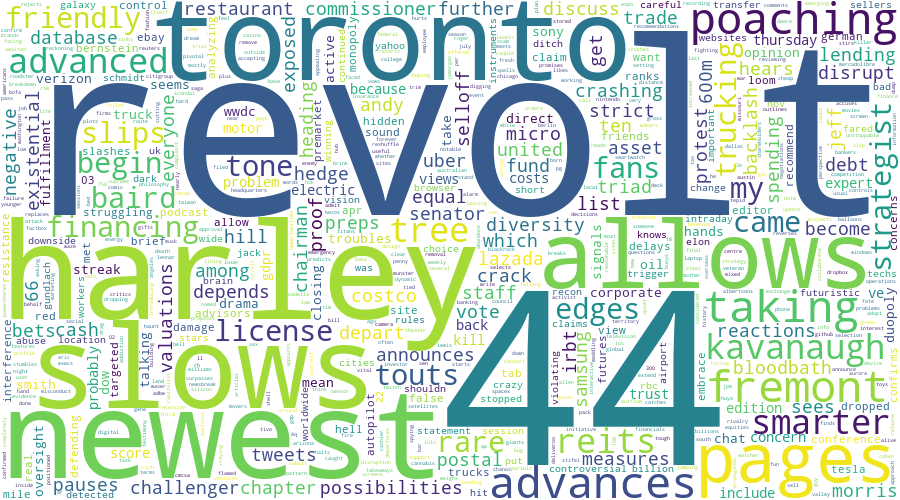

In [15]:
#And we could aslo build wordcould or do analysis with negative words.
#this is negative
wc.WordCloud(width=900,height=500, background_color="white",
             max_words=1628,
             relative_scaling=1,
             normalize_plurals=False).generate_from_frequencies(res.marginal_screening[res.marginal_screening['score']<0.5].set_index('term').to_dict()['score']).to_image()

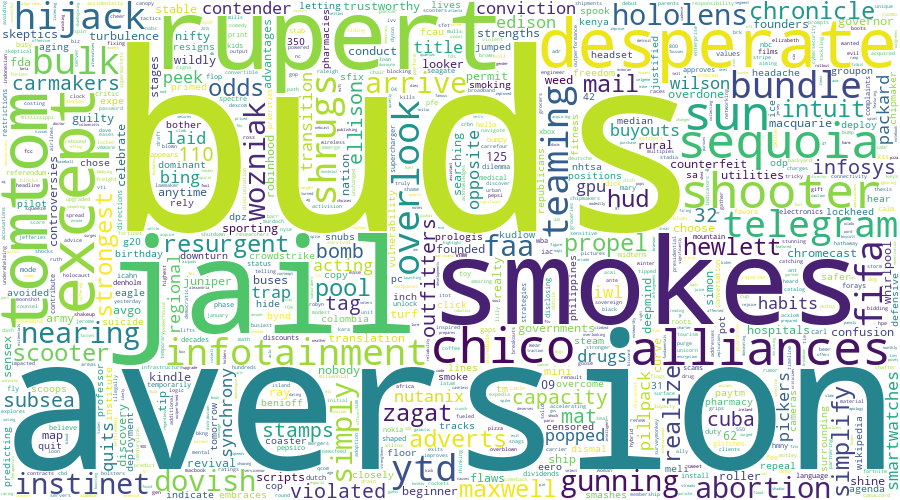

In [16]:
#And we could aslo build wordcould or do analysis with negative words.
#this is positive
wc.WordCloud(width=900,height=500, background_color="white",
             max_words=1628,
             relative_scaling=1,
             normalize_plurals=False).generate_from_frequencies(res.marginal_screening[res.marginal_screening['score']>0.5].set_index('term').to_dict()['score']).to_image()